In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

# Uploading Data and removing outliers and features

In [2]:
DROPPED = [
    "dist_360_SPEED", "dist_360_THROTTLE", "dist_360_STEER", "dist_360_BRAKE",
    "dist_360_CURRENTLAPTIMEINMS", "dist_360_LAPDISTANCE", "dist_360_WORLDPOSITIONX", "dist_360_WORLDPOSITIONY",
    "dist_360_WORLDFORWARDDIRX", "dist_360_WORLDFORWARDDIRY", "dist_360_YAW", "dist_360_PITCH",
    "dist_360_ROLL", "dist_360_left_dist", "dist_360_right_dist", "dist_360_dist_apex_1",
    "dist_360_dist_apex_2", "dist_360_angle_to_apex1", "dist_360_angle_to_apex2", "dist_360_proj_from_ref",
    "dist_430_SPEED", "dist_430_THROTTLE", "dist_430_STEER", "dist_430_BRAKE",
    "dist_430_CURRENTLAPTIMEINMS", "dist_430_LAPDISTANCE", "dist_430_WORLDPOSITIONX", "dist_430_WORLDPOSITIONY",
    "dist_430_WORLDFORWARDDIRX", "dist_430_WORLDFORWARDDIRY", "dist_430_YAW", "dist_430_PITCH",
    "dist_430_ROLL", "dist_430_left_dist", "dist_430_right_dist", "dist_430_dist_apex_1",
    "dist_430_dist_apex_2", "dist_430_angle_to_apex1", "dist_430_angle_to_apex2", "dist_430_proj_from_ref",
    "dist_530_SPEED", "dist_530_THROTTLE", "dist_530_STEER", "dist_530_BRAKE",
    "dist_530_CURRENTLAPTIMEINMS", "dist_530_LAPDISTANCE", "dist_530_WORLDPOSITIONX", "dist_530_WORLDPOSITIONY",
    "dist_530_WORLDFORWARDDIRX", "dist_530_WORLDFORWARDDIRY", "dist_530_YAW", "dist_530_PITCH",
    "dist_530_ROLL", "dist_530_left_dist", "dist_530_right_dist", "dist_530_dist_apex_1",
    "dist_530_dist_apex_2", "dist_530_angle_to_apex1", "dist_530_angle_to_apex2", "dist_530_proj_from_ref",
    "BPS_right_dist", "BPE_right_dist", "THS_right_dist", "THE_right_dist", "STS_right_dist",
    "STM_right_dist", "STE_right_dist", "APX1_right_dist", "APX2_right_dist", "BPS_CURRENTLAPTIMEINMS",
    "BPE_CURRENTLAPTIMEINMS", "THS_CURRENTLAPTIMEINMS", "THE_CURRENTLAPTIMEINMS", "STS_CURRENTLAPTIMEINMS",
    "STM_CURRENTLAPTIMEINMS", "STE_CURRENTLAPTIMEINMS", "APX1_CURRENTLAPTIMEINMS", "APX2_CURRENTLAPTIMEINMS"
]

In [3]:
data = pd.read_csv("final_data_product.csv")
data = data.dropna().drop_duplicates().drop(columns=DROPPED)
target_mean = data["Target_CURRENTLAPTIMEINMS"].mean()
target_std = data["Target_CURRENTLAPTIMEINMS"].std()
data = data[data['Target_CURRENTLAPTIMEINMS'] < target_mean + 3 * target_std] # removes 12 longest times
y = data["Target_CURRENTLAPTIMEINMS"]
X = data.drop(columns=["Target_CURRENTLAPTIMEINMS", "lap_id", "invalid_lap"])

target_columns = [
    'target_CURRENTLAPTIMEINMS', '_LAPDISTANCE', '_WORLDPOSITIONX', 
    '_WORLDPOSITIONY', '_STEER', '_BRAKE', '_THROTTLE', '_SPEED',
]

selected_columns = [col for col in X.columns if col.endswith(tuple(target_columns))]

X = X[selected_columns]

# Split and Scale

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    ElasticNet(max_iter=10000, random_state=42)
)

# GridSearch Best Params

In [5]:
param_grid = {
    "elasticnet__alpha": np.logspace(-3, 2, 10),
    "elasticnet__l1_ratio": np.linspace(0.05, 0.95, 10)
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV RMSE :", abs(grid.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'elasticnet__alpha': np.float64(0.1668100537200059), 'elasticnet__l1_ratio': np.float64(0.95)}
CV RMSE : 1898.8295615205018


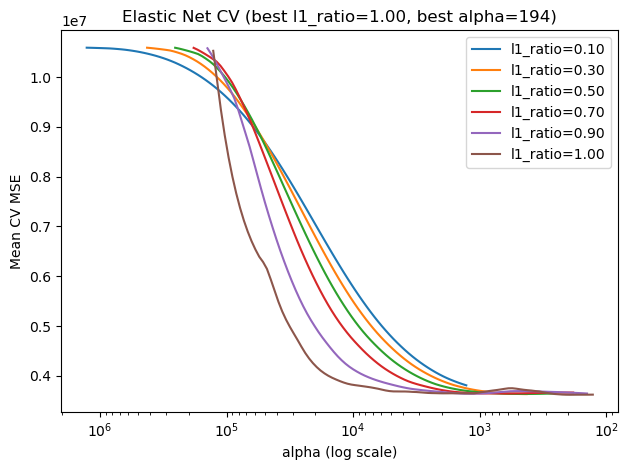

In [12]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.7,0.9,1.0],
                    alphas=None, cv=5, max_iter=200_000, n_jobs=-1)
enet.fit(X_train, y_train)

# enet is your fitted ElasticNetCV (or pipe.named_steps['elasticnetcv'])
mse_path = enet.mse_path_                  # (n_l1, n_alpha, n_folds) or (n_alpha, n_folds)
mean_mse = mse_path.mean(axis=-1)          # (n_l1, n_alpha) or (n_alpha,)
alphas   = enet.alphas_                    # (n_alpha,) or (n_l1, n_alpha)
l1_grid  = np.atleast_1d(getattr(enet, "l1_ratio", enet.l1_ratio_))

plt.figure()

if mean_mse.ndim == 1:
    # Only one l1_ratio tried
    # alphas shape: (n_alpha,)
    plt.plot(alphas, mean_mse, label=f"l1_ratio={float(l1_grid[0]):.2f}")
else:
    # Multiple l1_ratio values tried
    # mean_mse shape: (n_l1, n_alpha)
    # alphas can be (n_alpha,) OR (n_l1, n_alpha) depending on sklearn version
    if np.ndim(alphas) == 1:
        # same alpha grid for all l1_ratio rows
        for i, l1 in enumerate(l1_grid):
            plt.plot(alphas, mean_mse[i], label=f"l1_ratio={float(l1):.2f}")
    else:
        # different alpha grid per l1_ratio row
        for i, l1 in enumerate(l1_grid):
            plt.plot(alphas[i], mean_mse[i], label=f"l1_ratio={float(l1):.2f}")

plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("alpha (log scale)")
plt.ylabel("Mean CV MSE")
plt.title(f"Elastic Net CV (best l1_ratio={float(enet.l1_ratio_):.2f}, best alpha={float(enet.alpha_):.3g})")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
enet_best = enet  # or pipe.named_steps['elasticnetcv']
coef = enet_best.coef_
print("Best l1_ratio:", enet_best.l1_ratio_, "Best alpha:", enet_best.alpha_)
print("Non-zero coefficients:", (coef != 0).sum(), "out of", coef.size)

Best l1_ratio: 1.0 Best alpha: 193.83011434548078
Non-zero coefficients: 40 out of 69


In [19]:
try:
    feature_names = pipe.named_steps['columntransformer'].get_feature_names_out()
except:
    feature_names = X_train.columns

s = pd.Series(enet_best.coef_, index=feature_names, name="coef")

nonzero = s[s != 0].sort_values(key=np.abs, ascending=False)
zero    = s[s == 0]

print(f"Non-zero coefficients ({len(nonzero)}):")
print(nonzero.to_string())

print(f"\nZero coefficients ({len(zero)}):")
print(zero.index.tolist())

Non-zero coefficients (40):
STS_WORLDPOSITIONX    -60.501140
STS_WORLDPOSITIONY    -58.814002
BPS_WORLDPOSITIONX    -40.607820
BPS_WORLDPOSITIONY    -37.377667
BPE_WORLDPOSITIONX     35.637981
BPE_WORLDPOSITIONY     31.127354
STM_SPEED             -27.067481
STS_LAPDISTANCE       -25.191383
APX2_SPEED            -22.263831
APX1_WORLDPOSITIONX    19.433019
APX2_WORLDPOSITIONY    17.110427
STE_SPEED             -15.526413
THS_SPEED             -14.072836
APX1_SPEED             11.793787
THE_SPEED             -11.467445
STM_LAPDISTANCE        10.130068
THS_ext_LAPDISTANCE     9.523237
STS_SPEED              -9.513804
BPS_SPEED              -8.332003
APX1_LAPDISTANCE       -7.421190
BPS_LAPDISTANCE         6.734628
THE_LAPDISTANCE        -6.447061
THE_WORLDPOSITIONY      6.264227
STM_WORLDPOSITIONX      5.341534
THE_WORLDPOSITIONX      5.321530
BPE_ext_LAPDISTANCE    -5.190532
THS_LAPDISTANCE        -5.122351
STE_LAPDISTANCE         4.948982
STS_ext_LAPDISTANCE    -4.590982
BPS_ext_LAPDIST

Throttle, Steer, Brake for all key moments have zero coeff, why?

In [15]:
import numpy as np

# If you used a pipeline, uncomment the next line:
# enet = pipe.named_steps['elasticnetcv']

target_l1 = 1.0
target_alpha = 193.83011434548078

mse_path = enet.mse_path_            # (n_l1, n_alpha, n_folds) or (n_alpha, n_folds)
alphas   = enet.alphas_              # (n_alpha,) or (n_l1, n_alpha)
l1_grid  = np.atleast_1d(getattr(enet, "l1_ratio", enet.l1_ratio_)).astype(float)

# pick row for l1_ratio=1.0 (or closest)
i = 0 if mse_path.ndim == 2 else int(np.argmin(np.abs(l1_grid - target_l1)))

# pick matching alpha vector and index for alpha≈193.83
alpha_vec = alphas if np.ndim(alphas) == 1 else alphas[i]
j = int(np.argmin(np.abs(alpha_vec - target_alpha)))

# per-fold MSEs at that point → mean MSE → RMSE
mse_folds = mse_path if mse_path.ndim == 2 else mse_path[i]
cv_mse = float(np.mean(mse_folds[j]))
cv_rmse = float(np.sqrt(cv_mse))

print(f"l1_ratio used: {l1_grid[i]:.2f}")
print(f"alpha used: {alpha_vec[j]:.6g}")
print(f"CV RMSE: {cv_rmse:,.4f}")

l1_ratio used: 1.00
alpha used: 193.83
CV RMSE: 1,902.3470


# Test set Evaluation

In [6]:
grid_model = grid.best_estimator_
y_pred = grid_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:,.3f}")
print(f"Test R²  : {r2:,.3f}")
print(f"Test MAE : {mae:,.3f}")

Test RMSE: 1,633.853
Test R²  : 0.746
Test MAE : 892.442


In [7]:
grid_model = grid.best_estimator_
y_pred = grid_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)

# --- Adjusted R² ---
n = len(y_test)          # number of observations
p = X_test.shape[1]      # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Test RMSE      : {rmse:,.3f}")
print(f"Test Adj. R²   : {adj_r2:,.3f}")
print(f"Test MAE       : {mae:,.3f}")

Test RMSE      : 1,633.853
Test Adj. R²   : 0.560
Test MAE       : 892.442


# Coef

In [20]:
enet = final_model.named_steps["elasticnet"]
coefs = pd.Series(enet.coef_, index=X.columns).sort_values(key=np.abs, ascending=False)

print("\nTop 15 |coef| features:")
print(coefs.head(15))

# If you want positive / negative split:
top_pos = coefs[coefs > 0].head(10)
top_neg = coefs[coefs < 0].head(10)
print("\nTop positive coefficients:")
print(top_pos)
print("\nTop negative coefficients:")
print(top_neg)


Top 15 |coef| features:
STS_WORLDPOSITIONY   -1271.432539
STS_WORLDPOSITIONX   -1193.747061
APX2_SPEED            -989.577388
THS_SPEED             -793.489255
STE_SPEED             -790.432015
STM_SPEED             -615.357229
BPS_SPEED             -613.178233
BPE_WORLDPOSITIONX     591.023672
STM_STEER              566.400674
BPS_WORLDPOSITIONX    -508.428087
STE_LAPDISTANCE        455.514125
BPE_WORLDPOSITIONY     439.885032
THS_THROTTLE           439.790586
STM_LAPDISTANCE        432.562372
BPS_WORLDPOSITIONY    -414.976586
dtype: float64

Top positive coefficients:
BPE_WORLDPOSITIONX     591.023672
STM_STEER              566.400674
STE_LAPDISTANCE        455.514125
BPE_WORLDPOSITIONY     439.885032
THS_THROTTLE           439.790586
STM_LAPDISTANCE        432.562372
APX2_WORLDPOSITIONY    359.498345
BPS_LAPDISTANCE        347.226884
THS_WORLDPOSITIONX     294.534366
THE_WORLDPOSITIONX     255.470417
dtype: float64

Top negative coefficients:
STS_WORLDPOSITIONY   -1271.432539
STS_W

# Prediction

In [23]:
model = grid_model

In [28]:
percentiles = (0.000001, 0.95)
bounds = {f: (data[f].quantile(percentiles[0]), data[f].quantile(percentiles[1])) for f in X.columns}

rng = np.random.default_rng(42)
N = 50_000
Xcand = X.sample(N, replace=True, random_state=42)
ycand = model.predict(Xcand)

imin = int(np.argmin(ycand))
best_combo = Xcand.iloc[imin].to_dict()
best_pred  = ycand[imin]

print("\n=== Elastic Net-suggested setup (within observed range) ===")
for k, v in best_combo.items():
    print(f"{k}: {v:,.4f}")
print(f"Predicted Target_CURRENTLAPTIMEINMS: {best_pred:,.3f}")


=== Elastic Net-suggested setup (within observed range) ===
BPS_SPEED: 306.0000
BPS_THROTTLE: 1.0000
BPS_STEER: -0.0105
BPS_BRAKE: 0.0000
BPS_LAPDISTANCE: 266.0000
BPS_WORLDPOSITIONX: 298.5836
BPS_WORLDPOSITIONY: 282.8180
BPS_ext_LAPDISTANCE: 275.0000
BPE_SPEED: 260.0000
BPE_THROTTLE: 0.4000
BPE_STEER: 0.0377
BPE_BRAKE: 0.5757
BPE_LAPDISTANCE: 310.0000
BPE_WORLDPOSITIONX: 325.7499
BPE_WORLDPOSITIONY: 247.8683
BPE_ext_LAPDISTANCE: 417.0000
THS_SPEED: 305.0000
THS_THROTTLE: 0.8818
THS_STEER: -0.0016
THS_BRAKE: 0.1153
THS_LAPDISTANCE: 267.0000
THS_WORLDPOSITIONX: 298.5836
THS_WORLDPOSITIONY: 282.8180
THS_ext_LAPDISTANCE: 271.0000
THE_SPEED: 187.0000
THE_THROTTLE: 1.0000
THE_STEER: 0.0026
THE_BRAKE: 0.0000
THE_LAPDISTANCE: 417.0000
THE_WORLDPOSITIONX: 369.2132
THE_WORLDPOSITIONY: 167.8260
THE_ext_LAPDISTANCE: 417.0000
STS_SPEED: 312.0000
STS_THROTTLE: 1.0000
STS_STEER: 0.0004
STS_BRAKE: 0.0000
STS_LAPDISTANCE: 194.0000
STS_WORLDPOSITIONX: 250.5196
STS_WORLDPOSITIONY: 331.5493
STS_ext_LAPD

# Load Tracks for Exploration

In [39]:
LEFT_FILE  = "Track_Left.xlsx"
RIGHT_FILE = "Track_Right.xlsx"

def standardise_cols(data, side = "left"):
    data = data.copy()
    data.columns = data.columns.str.strip()
    lower = {c.lower(): c for c in data.columns}
    if side == "left":
        name_cols = [("left_worldposx", "left_worldposy")]
        outx, outy = "L_X", "L_Y"
    else:
        name_cols = [("right_worldposx", "right_worldposy")]
        outx, outy = "R_X", "R_Y"
    for xk, yk in name_cols:
        if xk in lower and yk in lower:
            data = data.rename(columns={lower[xk]: outx, lower[yk]: outy})
            break
        
    data[outx] = pd.to_numeric(data[outx], errors = "coerce")
    data[outy] = pd.to_numeric(data[outy], errors = "coerce")
    data = data.dropna(subset = [outx, outy])
    return data

left_data  = pd.read_excel(LEFT_FILE)
right_data = pd.read_excel(RIGHT_FILE)
left_data  = standardise_cols(left_data,  side = "left")
right_data = standardise_cols(right_data, side = "right")

def region_filter(data, xcol, ycol):
    return data.loc[(data[xcol] >= 90) & (data[ycol] <= 650) & (data[ycol] >= -215)].copy()

left_data  = region_filter(left_data,  "L_X", "L_Y")
right_data = region_filter(right_data, "R_X", "R_Y")

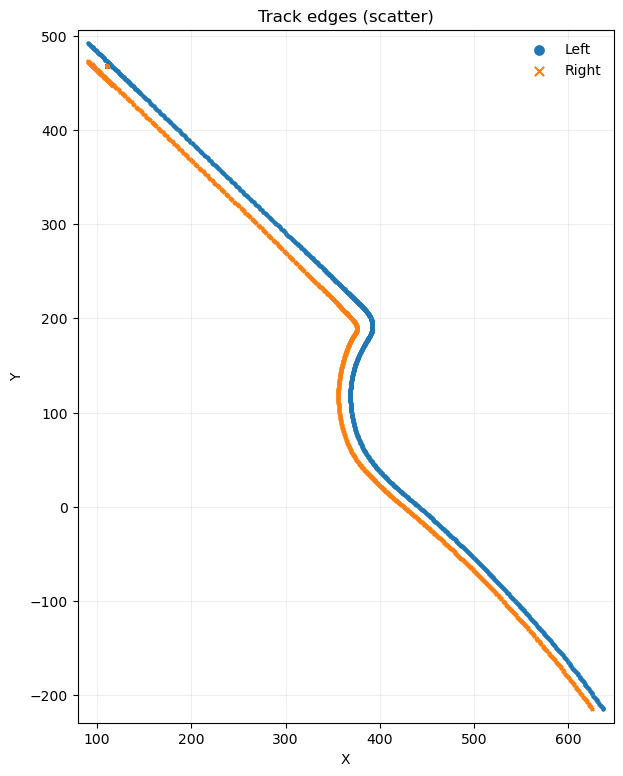

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 9))

ax.scatter(left_f["L_X"],  left_data["L_Y"],  s=5, marker="o", label="Left")
ax.scatter(right_f["R_X"], right_data["R_Y"], s=5, marker="x", label="Right")

ax.set_aspect("equal", adjustable="box")
ax.margins(0.02)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Track edges (scatter)")
ax.legend(markerscale=3, frameon=False)
ax.grid(True, alpha=0.2)

plt.show()

# Exploration of Predictions


In [30]:
# Build best_combo from your provided values
best_combo = {
    "BPS_SPEED": 306.0,
    "BPS_THROTTLE": 1.0,
    "BPS_STEER": -0.0105,
    "BPS_BRAKE": 0.0,
    "BPS_LAPDISTANCE": 266.0,
    "BPS_WORLDPOSITIONX": 298.5836,
    "BPS_WORLDPOSITIONY": 282.8180,
    "BPS_ext_LAPDISTANCE": 275.0,

    "BPE_SPEED": 260.0,
    "BPE_THROTTLE": 0.4,
    "BPE_STEER": 0.0377,
    "BPE_BRAKE": 0.5757,
    "BPE_LAPDISTANCE": 310.0,
    "BPE_WORLDPOSITIONX": 325.7499,
    "BPE_WORLDPOSITIONY": 247.8683,
    "BPE_ext_LAPDISTANCE": 417.0,

    "THS_SPEED": 305.0,
    "THS_THROTTLE": 0.8818,
    "THS_STEER": -0.0016,
    "THS_BRAKE": 0.1153,
    "THS_LAPDISTANCE": 267.0,
    "THS_WORLDPOSITIONX": 298.5836,
    "THS_WORLDPOSITIONY": 282.8180,
    "THS_ext_LAPDISTANCE": 271.0,

    "THE_SPEED": 187.0,
    "THE_THROTTLE": 1.0,
    "THE_STEER": 0.0026,
    "THE_BRAKE": 0.0,
    "THE_LAPDISTANCE": 417.0,
    "THE_WORLDPOSITIONX": 369.2132,
    "THE_WORLDPOSITIONY": 167.8260,
    "THE_ext_LAPDISTANCE": 417.0,

    "STS_SPEED": 312.0,
    "STS_THROTTLE": 1.0,
    "STS_STEER": 0.0004,
    "STS_BRAKE": 0.0,
    "STS_LAPDISTANCE": 194.0,
    "STS_WORLDPOSITIONX": 250.5196,
    "STS_WORLDPOSITIONY": 331.5493,
    "STS_ext_LAPDISTANCE": 203.0,

    "STM_SPEED": 312.0,
    "STM_THROTTLE": 1.0,
    "STM_STEER": 0.0004,
    "STM_BRAKE": 0.0,
    "STM_LAPDISTANCE": 197.0,
    "STM_WORLDPOSITIONX": 250.5196,
    "STM_WORLDPOSITIONY": 331.5493,

    "STE_SPEED": 312.0,
    "STE_THROTTLE": 1.0,
    "STE_STEER": -0.0,
    "STE_BRAKE": 0.0,
    "STE_LAPDISTANCE": 193.0,
    "STE_WORLDPOSITIONX": 244.2398,
    "STE_WORLDPOSITIONY": 337.5436,
    "STE_ext_LAPDISTANCE": 198.0,

    "APX1_SPEED": 201.0,
    "APX1_THROTTLE": 0.4,
    "APX1_STEER": 0.2961,
    "APX1_BRAKE": 0.3491,
    "APX1_LAPDISTANCE": 392.0,
    "APX1_WORLDPOSITIONX": 363.2926,
    "APX1_WORLDPOSITIONY": 188.3811,

    "APX2_SPEED": 162.0,
    "APX2_THROTTLE": 0.7116,
    "APX2_STEER": 0.1730,
    "APX2_BRAKE": 0.0,
    "APX2_LAPDISTANCE": 498.0,
    "APX2_WORLDPOSITIONX": 374.7213,
    "APX2_WORLDPOSITIONY": 88.2620,
}

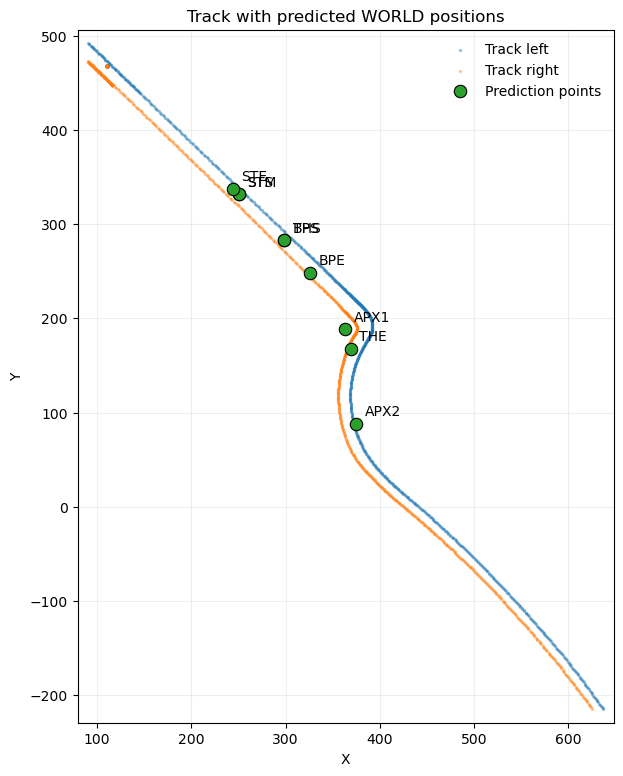

In [44]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- build df of WORLD positions from best_combo (your snippet) ---
pts = {}
for k, v in best_combo.items():
    m = re.match(r'([A-Z0-9]+)_WORLDPOSITION([XY])$', k)
    if m:
        prefix, axis = m.groups()
        pts.setdefault(prefix, {})[f'WORLDPOSITION{axis}'] = v

df = pd.DataFrame.from_dict(pts, orient="index").reset_index().rename(columns={"index": "Prefix"})

# --- plot ---
fig, ax = plt.subplots(figsize=(8, 9))

# track edges first (light + small)
ax.scatter(left_data["L_X"],  left_data["L_Y"],  s=2, alpha=0.35, label="Track left")
ax.scatter(right_data["R_X"], right_data["R_Y"], s=2, alpha=0.35, label="Track right")

# predicted WORLD positions on top (bigger markers with edge)
ax.scatter(
    df["WORLDPOSITIONX"], df["WORLDPOSITIONY"],
    s=80, marker="o", edgecolors="k", linewidths=0.8, zorder=3, label="Prediction points"
)

# labels with small offset so they don’t sit on the markers
for _, r in df.iterrows():
    ax.annotate(
        r["Prefix"],
        (r["WORLDPOSITIONX"], r["WORLDPOSITIONY"]),
        xytext=(6, 6), textcoords="offset points"
    )

ax.set_aspect("equal", adjustable="box")
ax.margins(0.02)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Track with predicted WORLD positions")
ax.grid(True, alpha=0.2)
ax.legend(frameon=False)

plt.show()

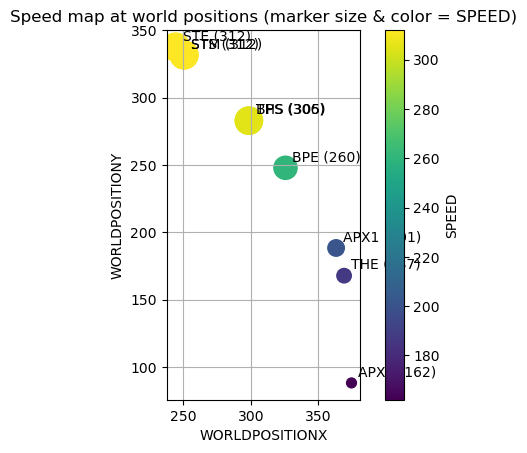

In [34]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- your values ---
best_combo = {
    "BPS_SPEED": 306.0, "BPS_WORLDPOSITIONX": 298.5836, "BPS_WORLDPOSITIONY": 282.8180,
    "BPE_SPEED": 260.0, "BPE_WORLDPOSITIONX": 325.7499, "BPE_WORLDPOSITIONY": 247.8683,
    "THS_SPEED": 305.0, "THS_WORLDPOSITIONX": 298.5836, "THS_WORLDPOSITIONY": 282.8180,
    "THE_SPEED": 187.0, "THE_WORLDPOSITIONX": 369.2132, "THE_WORLDPOSITIONY": 167.8260,
    "STS_SPEED": 312.0, "STS_WORLDPOSITIONX": 250.5196, "STS_WORLDPOSITIONY": 331.5493,
    "STM_SPEED": 312.0, "STM_WORLDPOSITIONX": 250.5196, "STM_WORLDPOSITIONY": 331.5493,
    "STE_SPEED": 312.0, "STE_WORLDPOSITIONX": 244.2398, "STE_WORLDPOSITIONY": 337.5436,
    "APX1_SPEED": 201.0, "APX1_WORLDPOSITIONX": 363.2926, "APX1_WORLDPOSITIONY": 188.3811,
    "APX2_SPEED": 162.0, "APX2_WORLDPOSITIONX": 374.7213, "APX2_WORLDPOSITIONY": 88.2620,
}

# collect per prefix
rows = {}
for k, v in best_combo.items():
    m = re.match(r'([A-Z0-9]+)_(SPEED|WORLDPOSITIONX|WORLDPOSITIONY)$', k)
    if m:
        prefix, field = m.groups()
        rows.setdefault(prefix, {})[field] = v

df = pd.DataFrame.from_dict(rows, orient="index").reset_index().rename(columns={"index": "Prefix"})
df = df.dropna(subset=["WORLDPOSITIONX", "WORLDPOSITIONY", "SPEED"])

# marker sizes mapped to SPEED (fixed ptp for NumPy 2.0)
smin, smax = 50, 400
sp = df["SPEED"].to_numpy()
rng = np.ptp(sp)  # range = max - min
rng = rng if rng != 0 else 1.0
sizes = smin + (sp - sp.min()) * (smax - smin) / rng

# plot
plt.figure()
sc = plt.scatter(df["WORLDPOSITIONX"], df["WORLDPOSITIONY"], c=df["SPEED"], s=sizes)
for _, r in df.iterrows():
    plt.annotate(f"{r['Prefix']} ({int(r['SPEED'])})",
                 (r["WORLDPOSITIONX"], r["WORLDPOSITIONY"]),
                 xytext=(5,5), textcoords="offset points")

plt.xlabel("WORLDPOSITIONX")
plt.ylabel("WORLDPOSITIONY")
plt.title("Speed map at world positions (marker size & color = SPEED)")
plt.grid(True)
plt.gca().set_aspect("equal", adjustable="box")
plt.colorbar(sc, label="SPEED")
plt.show()

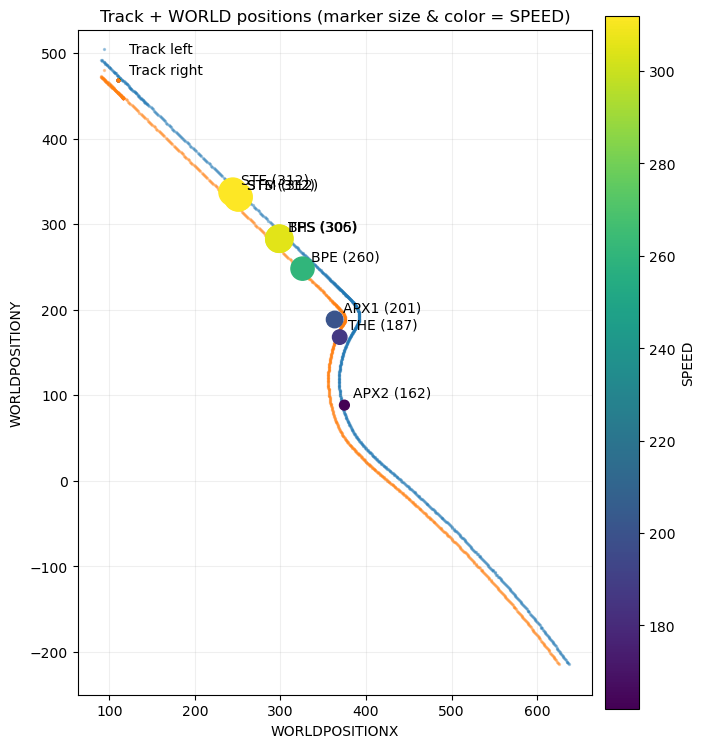

In [47]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- build df of WORLD positions + speed from best_combo ---
rows = {}
for k, v in best_combo.items():
    m = re.match(r'([A-Z0-9]+)_(SPEED|WORLDPOSITIONX|WORLDPOSITIONY)$', k)
    if m:
        prefix, field = m.groups()
        rows.setdefault(prefix, {})[field] = v

df = pd.DataFrame.from_dict(rows, orient="index").reset_index().rename(columns={"index": "Prefix"})
df = df.dropna(subset=["WORLDPOSITIONX", "WORLDPOSITIONY", "SPEED"])

# --- marker sizes mapped to SPEED (NumPy 2.x safe) ---
smin, smax = 50, 400
sp = df["SPEED"].to_numpy()
rng = np.ptp(sp) if np.ptp(sp) != 0 else 1.0
sizes = smin + (sp - sp.min()) * (smax - smin) / rng

# --- plot track + predictions ---
fig, ax = plt.subplots(figsize=(8, 9))

# track first (small, light)
ax.scatter(left_data["L_X"],  left_data["L_Y"],  s=2, alpha=0.35, label="Track left")
ax.scatter(right_data["R_X"], right_data["R_Y"], s=2, alpha=0.35, label="Track right")

# predictions on top (color & size by SPEED)
sc = ax.scatter(df["WORLDPOSITIONX"], df["WORLDPOSITIONY"], c=df["SPEED"], s=sizes, zorder=3)

# labels
for _, r in df.iterrows():
    ax.annotate(f"{r['Prefix']} ({int(r['SPEED'])})",
                (r["WORLDPOSITIONX"], r["WORLDPOSITIONY"]),
                xytext=(6, 6), textcoords="offset points")

ax.set_xlabel("WORLDPOSITIONX")
ax.set_ylabel("WORLDPOSITIONY")
ax.set_title("Track + WORLD positions (marker size & color = SPEED)")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.2)
ax.legend(frameon=False, loc="upper left")

cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("SPEED")

plt.show()